In [30]:
import mne
import numpy as np
from scipy import stats
import seaborn as sns
import pandas as pd
import os
import re

# Multiprocessing
import deepgraph as dg
from multiprocessing import Pool

import torch


In [35]:
%matplotlib inline
cmap = sns.cm.rocket_r

# Data Preparation

In [67]:
# Common functions
def get_eeg_file(unique_id): 
  rootdir = "./Data"
  sub,  taks = unique_id.split('_')
  regex = re.compile('(.*{}.*{}.*edf$)'.format(sub, taks))

  for root, dirs, files in os.walk(rootdir):
    for file in files:
      if regex.match(file):
        return file
      
def split_given_size(a, size):
    new_array =  np.array_split(a, np.arange(size,a.shape[1],size), axis=1)
    if(new_array[-1].shape[1] < new_array[0].shape[1]):
        new_array = new_array[:-1]
    return new_array

def get_raw_eeg(filename, root_dir = "./Data/"):
    raw = mne.io.read_raw_edf(root_dir + filename)
    return raw
#split_given_size(np.arange(1000),7)

In [75]:
def graph_corr_matrix(corr, channels):
    sns.heatmap(np.average(corr, axis=0), cmap=cmap, vmax=1, vmin=0, xticklabels=channels, yticklabels=channels)

In [4]:
df = pd.read_excel("Demographic_List.xlsx")

df.head(10)

,sub,Age,Gender,Study,count,session,Condition,task,Headset
0,9003,41,F,INSPECDS,286,900301000,HC,RSEC,X24
1,9003,41,F,INSPECDS,296,900301000,HC,RSEO,X24
2,9004,66,F,INSPECDS,266,900401000,HC,RSEC,X24
3,9004,66,F,INSPECDS,285,900401000,HC,RSEO,X24
4,9006,52,M,INSPECDS,288,900601000,HC,RSEC,X24
5,9006,52,M,INSPECDS,291,900601000,HC,RSEO,X24
6,9008,53,F,INSPECDS,291,900801000,HC,RSEC,X24
7,9008,53,F,INSPECDS,290,900801000,HC,RSEO,X24
8,9009,48,F,INSPECDS,292,900901000,HC,RSEC,X24
9,9009,48,F,INSPECDS,279,900901000,HC,RSEO,X24


In [5]:
df.groupby("Condition").count()

,sub,Age,Gender,Study,count,session,task,Headset
Condition,,,,,,,,
AD,52,52,52,52,52,52,52,52
HC,224,224,224,224,224,224,224,224
MCI,107,107,107,107,107,107,107,107


In [6]:
conditions = set(df["Condition"])
conditions

{'AD', 'HC', 'MCI'}

In [70]:
# Preprocessing
df["unique_id"] = df["sub"].astype(str) + "_" + df["task"]
df["filename"] = df["unique_id"].apply(get_eeg_file)
df = df[df["Condition"] != "MCI"]

#df.to_csv("dataframe.csv")
df.head()

,sub,Age,Gender,Study,count,session,Condition,task,Headset,unique_id,filename
0,9003,41,F,INSPECDS,286,900301000,HC,RSEC,X24,9003_RSEC,INSPEC.INIT.900301000.010217.104300.Signals.Ra...
1,9003,41,F,INSPECDS,296,900301000,HC,RSEO,X24,9003_RSEO,INSPEC.INIT.900301000.010217.104300.Signals.Ra...
2,9004,66,F,INSPECDS,266,900401000,HC,RSEC,X24,9004_RSEC,INSPEC.INIT.900401000.070217.105622.Signals.Ra...
3,9004,66,F,INSPECDS,285,900401000,HC,RSEO,X24,9004_RSEO,INSPEC.INIT.900401000.070217.105622.Signals.Ra...
4,9006,52,M,INSPECDS,288,900601000,HC,RSEC,X24,9006_RSEC,INSPEC.INIT.900601000.130217.115256.Signals.Ra...


In [ ]:
# Read EEG raw files and save them in a dict for later use 
raw_files = {} 
eeg_min_size = 308224
for _, s in df.iterrows(): 
    raw_files[s["unique_id"]] = get_raw_eeg(s["filename"])
    shape = raw_files[s["unique_id"]].get_data().shape[1] 
    eeg_min_size = shape if shape < eeg_min_size else eeg_min_size

eeg_min_size

In [26]:
eeg_max_size = 1024
n_features = 20
n_samples = len(raw_files) 
channels = raw_files["9003_RSEC"].ch_names[:20]


In [44]:
new_df = []
X = np.zeros((n_samples, n_features, eeg_max_size))
X.shape
# Fill matrix X with data 
for i, s in df.iterrows(): 
    raw = raw_files[s["unique_id"]]
    shape = raw.get_data().shape[1]
    data = raw.get_data(channels) 
    #data = np.pad(data, [(0,0),(0, eeg_max_size-shape )], 'wrap')
    #print(data.shape)
    data = split_given_size(data, 1024*5)
    #print(len(data))
    for i, d in enumerate(data): 
        raw = torch.Tensor(d)
        corr = torch.corrcoef(raw)
        object = {
            "UID" : s["unique_id"] + "_{}".format(i), 
            "Condition" : s["Condition"],
            "Correlation" : corr.numpy()
        }
        new_df.append(object)

In [54]:
new_df = []
X = np.zeros((n_samples, n_features, eeg_max_size))
X.shape
# Fill matrix X with data 
for i, s in df.iterrows(): 
    raw = raw_files[s["unique_id"]]
    shape = raw.get_data().shape[1]
    data = raw.get_data(channels) 
    #data = np.pad(data, [(0,0),(0, eeg_max_size-shape )], 'wrap')
    #print(data.shape)
    data = split_given_size(data, 1024*5)
    #print(len(data))
    corr = np.zeros((20,20))
    for i, d in enumerate(data): 
        raw = torch.Tensor(d)
        corr += torch.corrcoef(raw).numpy()

    corr = corr/len(data)
    object = {
        "UID" : s["unique_id"],
        "Condition" : s["Condition"],
        "Correlation" : corr
    }   
    new_df.append(object)

In [55]:
new_df = pd.DataFrame(new_df)
new_df.head()

,UID,Condition,Correlation
0,9003_RSEC,HC,"[[0.999999980131785, 0.8600083947181701, 0.501..."
1,9003_RSEO,HC,"[[0.9999999870856603, 0.8786274378498395, 0.81..."
2,9004_RSEC,HC,"[[0.9999999821186065, 0.8172817707061768, 0.70..."
3,9004_RSEO,HC,"[[0.9999999811251958, 0.9762072493632634, 0.94..."
4,9006_RSEC,HC,"[[0.9999999721844991, 0.9290434256196022, 0.59..."


In [63]:
new_df.to_pickle("Results/corr_dataset_5_seconds_avg.pkl")

In [ ]:
pd.read_pickle("corr_dataset.pkl")

In [57]:
hc_idx = list(np.where(new_df["Condition"] == "HC")[0])
ad_idx = list(np.where(new_df["Condition"] == "AD")[0])
corr_hc = np.zeros((20,20))
corr_ad = np.zeros((20,20))

In [58]:
for i in hc_idx: 
    corr_hc += new_df.loc[i]["Correlation"]
corr_hc = corr_hc/len(hc_idx)
for i in ad_idx: 
    corr_ad += new_df.loc[i]["Correlation"]

corr_ad = corr_ad/len(ad_idx)

<AxesSubplot:>

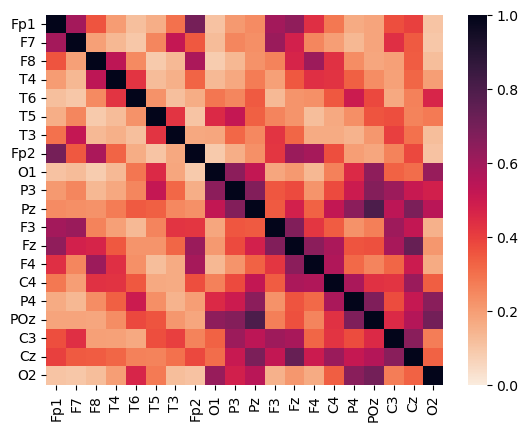

In [59]:


sns.heatmap(corr_hc**2, cmap=cmap, vmax=1, vmin=0, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

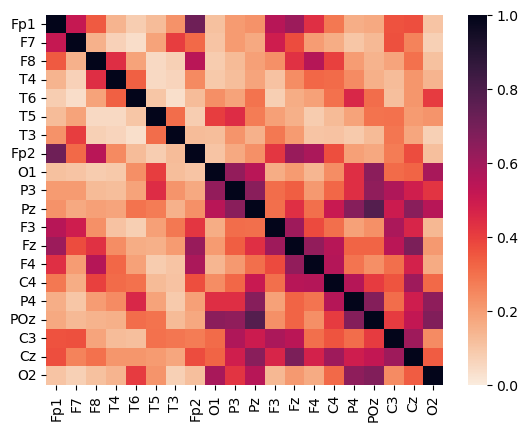

In [60]:
sns.heatmap(corr_ad**2, cmap=cmap, vmax=1, vmin=0, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

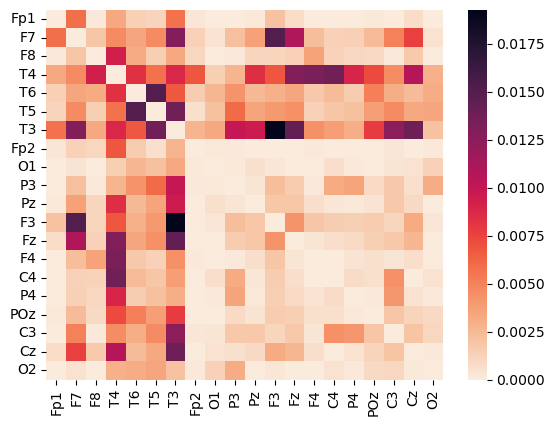

In [62]:
sns.heatmap((corr_hc**2-corr_ad**2)**2, cmap=cmap, xticklabels=channels, yticklabels=channels)

In [34]:
np.save('samples_corr', X_corr)
np.save('p_values', p_corr)

# Paper Dataset